In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos
import sw_and_int_one_sess as sios

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_disinhibition'
figdir = misc.get_or_create_subdir(figdir)

In [4]:
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

# gpb=per_field_metrics_all.groupby(level=(0,1,4),sort=False)
# fr_nrem_all = []
# for k,val in gpb:
#     fr_nrem=np.ones(val.shape[0]) * cell_metrics_df_all.loc[k,'firingRate_NREMstate']
#     fr_nrem_all.append(pd.Series(fr_nrem,index=val.index))
# fr_nrem_all = pd.concat(fr_nrem_all,axis=0)
    

# per_field_metrics_all['fr_nrem']=fr_nrem_all

In [5]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


In [6]:
import switch_detection_sweep_penalty_one_session as sdspos
import get_all_switch_add_metrics_pen as gasamp
reload(gasamp)
pen=0.5#0.3#0.3#0.5

best_n_all = {}
X_pwc_all={}
X_raw_all={}
changes_df_all={}
var_res_all={}
corr_all = {}
p_corr_all = {}
all_sw_d_all={}
all_sw_with_metrics_d_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    sw_res_pelt = sdspos.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    
    sw_info_res_pelt=gasamp.main(data_dir_full,force_reload=False,load_only=True,dosave=False)
    if sw_info_res_pelt is None:
        sw_info_res_pelt=gasamp.main(data_dir_full,force_reload=True,load_only=False)
    all_sw_d = sw_info_res_pelt['all_sw_d_pen'][pen]
    all_sw_d_all[ani,sess] = all_sw_d
    all_sw_with_metrics_d = sw_info_res_pelt['all_sw_with_metrics_d_pen'][pen]
    all_sw_with_metrics_d_all[ani,sess] = all_sw_with_metrics_d
    
    all_sw_res= gasamp.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    sw_res_pelt = sw_res_pelt[pen]
    
    best_n_all[ani,sess]=sw_res_pelt['best_n']
    X_pwc_all[ani,sess]=sw_res_pelt['X_pwc']
    X_raw_all[ani,sess]=sw_res_pelt['X_raw']
    changes_df_all[ani,sess]=sw_res_pelt['changes_df']
    var_res_all[ani,sess]=sw_res_pelt['var_res']
    corr_all[ani,sess]=sw_res_pelt['corr']
    p_corr_all[ani,sess]=sw_res_pelt['p_corr']
    
best_n_all = pd.concat(best_n_all,axis=0)
X_pwc_all = pd.concat(X_pwc_all,axis=0)
X_raw_all = pd.concat(X_raw_all,axis=0)
changes_df_all = pd.concat(changes_df_all,axis=0)
var_res_all = pd.concat(var_res_all,axis=0)
corr_all = pd.concat(corr_all,axis=0)
p_corr_all = pd.concat(p_corr_all,axis=0)

all_sw_d_all=pd.concat(all_sw_d_all,axis=0)
all_sw_with_metrics_d_all = pd.concat(all_sw_with_metrics_d_all,axis=0)


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/switch_analysis/all_sw_info_pe

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/switch_analysis/all_sw_info_pen.p ex

In [17]:
ani,sess='e13_26m1','e13_26m1_210913'
X_raw_one_tt=X_raw_all.loc[ani,sess].loc[0,0]

/tmp/ipykernel_655924/4239422097.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_raw_one_tt=X_raw_all.loc[ani,sess].loc[0,0]


In [12]:
spk_beh_df = spk_beh_df_all.loc[ani,sess]

/tmp/ipykernel_655924/463252252.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[ani,sess]


In [25]:
trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df)

In [7]:
import peer_prediction as pp
reload(pp)

<module 'peer_prediction' from '/mnt/home/szheng/projects/place_variability/code/peer_prediction.py'>

In [109]:
# import sw_and_int_withreg as saiw
# reload(saiw)
# data_dir_full = subdb.iloc[-1]['data_dir_full']
# res=saiw.main(data_dir_full,dosave=False,force_reload=True)

# res_old=saiw.main(data_dir_full,dosave=False,force_reload=False)

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201118/py_data/fr_map_with_int.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201118/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201118/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201118/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201118/py_data/place_field_afterheadscan_recombine.p exists; loading---


/mnt/home/szheng/projects/place_variability/code/sw_and_int_withreg.py:90: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_field_metrics_one = per_field_metrics_all.loc[(ani,sess),:]


In [95]:
# X_raw_one_row = X_raw_one_tt
# ti=0
# tt=0
# pp.get_min_max_tick(X_raw_one_row.iloc[0],trial_index_to_index_within_df,ti,tt)

array([1, 2])

In [93]:
# all_sw_with_metrics = all_sw_with_metrics_d_all.loc[ani,sess]
# uid = 121
# field_id=0
# ti=0
# tt=0

/tmp/ipykernel_655924/1096087013.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_with_metrics = all_sw_with_metrics_d_all.loc[ani,sess]


In [90]:
# reload(pp)
# X_raw_one = X_raw_all.loc[ani,sess]
# pp.get_trials_to_exclude_onefield(all_sw_with_metrics,X_raw_one,uid,field_id,ti,tt,\
#                                   trial_index_to_index_within_df
#                                  )




/tmp/ipykernel_655924/3372494215.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_raw_one = X_raw_all.loc[ani,sess]


174    23
Name: trial_index, dtype: int64

In [7]:
import peer_prediction as pp
reload(sios)
consec_trial_fr_diff_all = {}
sustained_all = {}
transient_all={}
all_sw_with_inh_change_all = {}
for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    sw_and_int_res=sios.main(data_dir_full,force_reload=False,load_only=True)
    consec_trial_fr_diff=sw_and_int_res['consec_trial_fr_diff_all']
    sustained=sw_and_int_res['sustained']
    transient =sw_and_int_res['transient']
    consec_trial_fr_diff_all[ani,sess] = consec_trial_fr_diff
    sustained_all[ani,sess] = sustained
    transient_all[ani,sess] = transient
    
    all_sw_with_inh_change = sw_and_int_res['all_sw_with_metrics_oneti_with_inh_change']
    all_sw_with_inh_change_all[ani,sess]=all_sw_with_inh_change
    



    
all_sw_with_inh_change_all=pd.concat(all_sw_with_inh_change_all,axis=0)
    
consec_trial_fr_diff_all = pd.concat(consec_trial_fr_diff_all,axis=0)
sustained_all = pd.concat(sustained_all,axis=0)
transient_all = pd.concat(transient_all,axis=0)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_and_int_pen_5e-01.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_and_int_pen_5e-01.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/sw_and_int_pen_5e-01.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/sw_and_int_pen_5e-01.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/sw_and_int_pen_5e-01.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/sw_and_int_pen_5e-01.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/sw_and_int_pen_5e-01.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/sw_and_int_pen_5e-01.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/sw_and_in

In [8]:
import sw_and_int_withreg as saiw
reload(saiw)

import peer_prediction as pp
reload(sios)
consec_trial_fr_diff_all = {}
sustained_all = {}
transient_all={}
all_sw_with_inh_change_all = {}
for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    sw_and_int_res=saiw.main(data_dir_full,force_reload=False,load_only=True)
    consec_trial_fr_diff=sw_and_int_res['consec_trial_fr_diff_all']
    sustained=sw_and_int_res['sustained']
    transient =sw_and_int_res['transient']
    consec_trial_fr_diff_all[ani,sess] = consec_trial_fr_diff
    sustained_all[ani,sess] = sustained
    transient_all[ani,sess] = transient
    
    all_sw_with_inh_change = sw_and_int_res['all_sw_with_metrics_oneti_with_inh_change']
    all_sw_with_inh_change_all[ani,sess]=all_sw_with_inh_change
    



    
all_sw_with_inh_change_all=pd.concat(all_sw_with_inh_change_all,axis=0)
    
consec_trial_fr_diff_all = pd.concat(consec_trial_fr_diff_all,axis=0)
sustained_all = pd.concat(sustained_all,axis=0)
transient_all = pd.concat(transient_all,axis=0)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/sw_and_int_exclude_sw_large

# grouped by inh or disinhibition, lasting effect

In [261]:
data

trialtype  uid  field_index         time  \
e13_26m1 e13_26m1_210913 0 3        1.0  150            1  7982.510696   
                           10      both   93            0  7966.197042   
                           15       1.0  285            0  7993.315150   
                           18       1.0  428            0  7989.344501   
                           22       0.0  157            1  8035.490303   
...                                 ...  ...          ...          ...   
e14_2m3  e14_2m3_201118  0 12       0.0   26            1  7668.230379   
                           13       1.0   23            1  7705.143048   
                           14       0.0   34            0  7870.450625   
                           15       0.0   35            0  7823.155196   
                           16      both   26            0  7817.548795   

                               speed_gauss  field_pos  trial_index  switch  \
e13_26m1 e13_26m1_210913 0 3     23.065528  75.824816            4     1.0   
                           10    40.872632  15.184165            4     1.0   
                           15    21.516716  42.045592            5     1.0   
                           18     8.507714   4.927719            5     1.0   
                           22    21.913613  96.619631            6     1.0   
...                                    ...        ...          ...     ...   
e14_2m3  e14_2m3_201118  0 12     8.202816  91.345415           10     1.0   
                           13    22.605171  31.444798           11     1.0   
                           14    25.841988  96.369145           14     1.0   
                           15     4.717832  40.458962           14     1.0   
                           16    38.765659   5.930841           14     1.0   

                               index_within  switch_trial  ...  \
e13_26m1 e13_26m1_210913 0 3              2           2.0  ...   
                           10             2           4.0  ...   
                           15             3           3.0  ...   
                           18             3           3.0  ...   
                           22             2           2.0  ...   
...                                     ...           ...  ...   
e14_2m3  e14_2m3_201118  0 12             7           7.0  ...   
                           13             3           3.0  ...   
                           14             9           9.0  ...   
                           15             9           9.0  ...   
                           16             9          14.0  ...   

                               post_ntrial_le_30_perc_frac_total  \
e13_26m1 e13_26m1_210913 0 3                            0.000000   
                           10                           0.071429   
                           15                           0.000000   
                           18                           0.054054   
                           22                           0.000000   
...                                                          ...   
e14_2m3  e14_2m3_201118  0 12                           0.000000   
                           13                           0.000000   
                           14                           0.000000   
                           15                           0.000000   
                           16                           0.041667   

                               post_ntrial_le_50_perc_frac_total  \
e13_26m1 e13_26m1_210913 0 3                            0.027027   
                           10                           0.342857   
                           15                           0.081081   
                           18                           0.135135   
                           22                           0.000000   
...                                                          ...   
e14_2m3  e14_2m3_201118  0 12                           0.000000   
                           13                     

In [13]:
data=copy.copy(consec_trial_fr_diff_all)
data['unselected_inh'] = data['inh'] - data['selected_inh']


ti=0
all_sw_with_metrics_d_all_oneti = all_sw_with_metrics_d_all.loc[(slice(None),slice(None),ti),:]
onoff_str_d = {1:'on',-1:'off'}
for sw in [1,-1]:
    sw_data=all_sw_with_metrics_d_all_oneti.query('switch==@sw')

    inds=[sw_data.index.get_level_values(0),
        sw_data.index.get_level_values(1),
        sw_data['trialtype'],sw_data['uid'],
        sw_data['field_index'],
        sw_data['switch_trial']-1,
         ]
    # for each switch trial, the reference trial should be the one before that


    inds=pd.MultiIndex.from_arrays(inds)


    onoff_str = onoff_str_d[sw]
    data[f'has_sw_{onoff_str}'] = False
    data.loc[inds,f'has_sw_{onoff_str}']=True

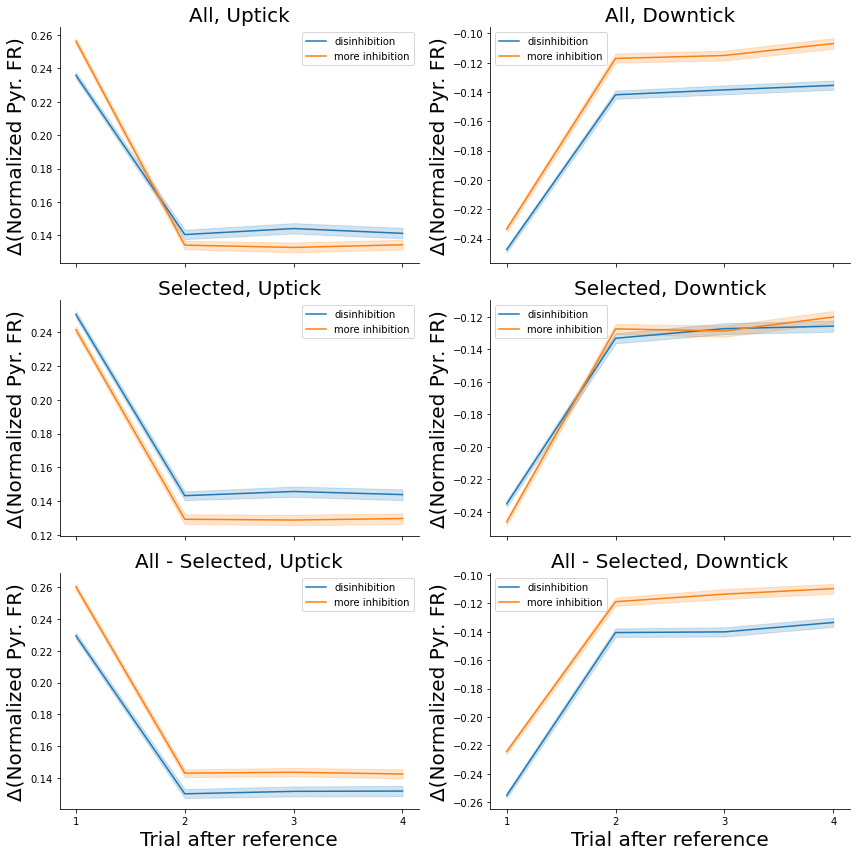

In [116]:
cols_reset = np.arange(1,5)
var_name='Trial after reference'
ylabel = u'Δ(Normalized Pyr. FR)'
kwargs = dict(cols_reset=cols_reset,var_name=var_name)
title_key_d = {'inh':'All','selected_inh':'Selected','unselected_inh':'All - Selected'}
int_thresh = 0
pyr_thresh = 0
ma_updown_d = {'Uptick':data['pyr_1']>pyr_thresh,
               'Downtick':data['pyr_1']<-pyr_thresh
              }
fig,axs=plt.subplots(3,2,figsize=(2*6,3*4),sharex=True)
for ii,(updown, ma_updown) in enumerate(ma_updown_d.items()):
    for jj,inh_key in enumerate(['inh','selected_inh','unselected_inh']):
        
        ax = axs[jj,ii]
#         ma = (data['pyr_1']>pyr_thresh) & (data[inh_key] < -int_thresh)
        ma = ma_updown & (data[inh_key] < -int_thresh)
        toplot=data.loc[ma].loc[:,'pyr_1':'pyr_4']
        fig,ax=ph.mean_across_row_vs_col_with_err(toplot,label='disinhibition',fig=fig,ax=ax,**kwargs)


#         ma = (data['pyr_1']>pyr_thresh) & (data[inh_key] > int_thresh)
        ma = ma_updown & (data[inh_key] > int_thresh)
        toplot=data.loc[ma].loc[:,'pyr_1':'pyr_4']
        fig,ax=ph.mean_across_row_vs_col_with_err(toplot,label='more inhibition',fig=fig,ax=ax,**kwargs)
        ax.set(ylabel=ylabel)
        title = f'{title_key_d[inh_key]}, {updown}'
        ax.set_title(title)
        sns.despine()
plt.tight_layout()

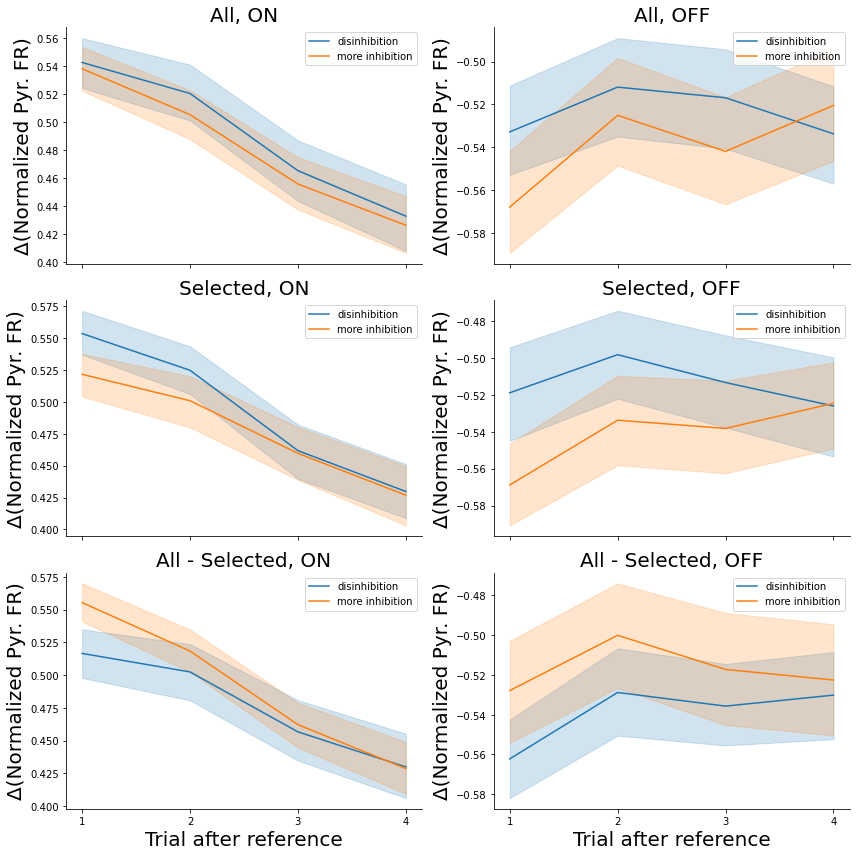

In [266]:
cols_reset = np.arange(1,5)
var_name='Trial after reference'
ylabel = u'Δ(Normalized Pyr. FR)'
kwargs = dict(cols_reset=cols_reset,var_name=var_name)
title_key_d = {'inh':'All','selected_inh':'Selected','unselected_inh':'All - Selected'}
ma_updown_d = {'ON':data['has_sw_on'],
               'OFF':data['has_sw_off']
              }
fig,axs=plt.subplots(3,2,figsize=(2*6,3*4),sharex=True)
for ii,(updown, ma_updown) in enumerate(ma_updown_d.items()):
    for jj,inh_key in enumerate(['inh','selected_inh','unselected_inh']):
        int_thresh = 0
        pyr_thresh = 0
        ax = axs[jj,ii]
#         ma = (data['pyr_1']>pyr_thresh) & (data[inh_key] < -int_thresh)
        ma = ma_updown & (data[inh_key] < -int_thresh)
        toplot=data.loc[ma].loc[:,'pyr_1':'pyr_4']
        fig,ax=ph.mean_across_row_vs_col_with_err(toplot,label='disinhibition',fig=fig,ax=ax,**kwargs)


#         ma = (data['pyr_1']>pyr_thresh) & (data[inh_key] > int_thresh)
        ma = ma_updown & (data[inh_key] > int_thresh)
        toplot=data.loc[ma].loc[:,'pyr_1':'pyr_4']
        fig,ax=ph.mean_across_row_vs_col_with_err(toplot,label='more inhibition',fig=fig,ax=ax,**kwargs)
        ax.set(ylabel=ylabel)
        title = f'{title_key_d[inh_key]}, {updown}'
        ax.set_title(title)
        sns.despine()
plt.tight_layout()

In [ ]:
data = copy.copy(consec_trial_fr_diff_all)


In [162]:
import statsmodels
import statsmodels.formula.api as smf

In [219]:
data_for_reg = copy.copy(data)
pyr_thresh = 0
# data_for_reg = data_for_reg.loc[data_for_reg['pyr_1'] > pyr_thresh]
data_for_reg = data_for_reg.loc[data_for_reg['pyr_1'] <- pyr_thresh]
# data_for_reg = data_for_reg.loc[(data_for_reg['pyr_1'] > pyr_thresh)&(data_for_reg['pyr_2'] > pyr_thresh)]
# data_for_reg = data_for_reg.loc[(data_for_reg['pyr_1'] <- pyr_thresh)&(data_for_reg['pyr_2'] > pyr_thresh)]

In [207]:
res_control=smf.ols('pyr_3~int_3',data=data_for_reg).fit()
print(res_control.summary())
data_for_reg['resid'] = data_for_reg['pyr_3'] - res_control.resid
res_final = smf.ols('resid~C(inh_sign)',data=data_for_reg).fit()
res_final.summary()

                            OLS Regression Results                            
Dep. Variable:                  pyr_3   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     443.6
Date:                Wed, 20 Sep 2023   Prob (F-statistic):           3.20e-98
Time:                        17:34:30   Log-Likelihood:                -15573.
No. Observations:               81679   AIC:                         3.115e+04
Df Residuals:                   81677   BIC:                         3.117e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1380      0.001    134.668      0.0

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/pandas/core/indexes/multi.py:3635: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  result = lib.fast_unique_multiple([self._values, rvals], sort=sort)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  resid   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                 1.296e+04
Date:                Wed, 20 Sep 2023   Prob (F-statistic):               0.00
Time:                        17:34:30   Log-Likelihood:             2.0344e+05
No. Observations:               81679   AIC:                        -4.069e+05
Df Residuals:                   81677   BIC:                        -4.069e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1297      0.000   1271.340      0.000       0.130       0.130
C(inh_sign)[T.True]     0.0160      0.000    113.844      0.000       0.016       0.016
==============================================================================
Omnibus:                    32265.638   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5600178.388
Skew:                          -0.801   Prob(JB):                         0.00
Kurtosis:                      43.533   Cond. No.                         2.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [226]:
# res_total = smf.ols('pyr_2~C(inh_sign)+int_2',data=data_for_reg).fit()
# res_total = smf.ols('pyr_2~int_1+int_2',data=data_for_reg).fit()
# res_total = smf.ols('pyr_1~int_1',data=data_for_reg).fit()
# res_total = smf.ols('pyr_2~int_1',data=data_for_reg).fit()
res_total = smf.ols('pyr_2~C(inh_sign)',data=data_for_reg).fit()
res_total.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pyr_2   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     127.9
Date:                Wed, 20 Sep 2023   Prob (F-statistic):           1.25e-29
Time:                        17:42:17   Log-Likelihood:                -23648.
No. Observations:               85535   AIC:                         4.730e+04
Df Residuals:                   85533   BIC:                         4.732e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.1419      0.001    -96.786      0.000      -0.145      -0.139
C(inh_sign)[T.True]     0.0248      0.002     11.309      0.000       0.021       0.029
==============================================================================
Omnibus:                      499.122   Durbin-Watson:                   2.452
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              742.777
Skew:                           0.001   Prob(JB):                    5.11e-162
Kurtosis:                       3.457   Cond. No.                         2.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
res_control=smf.ols('pyr_2~int_2',data=data_for_reg).fit()
data_for_reg['resid'] = data_for_reg['pyr_2'] - res_control.resid
res_final = smf.ols('resid~C(inh_sign)',data=data_for_reg).fit()
res_final.summary()

In [199]:
smf.ols('pyr_2~C(inh_sign)',data=data_for_reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pyr_2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.72
Date:                Wed, 20 Sep 2023   Prob (F-statistic):            0.00106
Time:                        17:25:45   Log-Likelihood:                -14521.
No. Observations:               87652   AIC:                         2.905e+04
Df Residuals:                   87650   BIC:                         2.906e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1406      0.001     99.856      0.000       0.138       0.143
C(inh_sign)[T.True]    -0.0063      0.002     -3.273      0.001      -0.010      -0.003
==============================================================================
Omnibus:                     2667.133   Durbin-Watson:                   2.370
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3160.263
Skew:                           0.387   Prob(JB):                         0.00
Kurtosis:                       3.515   Cond. No.                         2.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# difference in pre switch

In [178]:
def get_peri_switch_x_raw_grouped(all_sw_inh_all,X_raw_all,ti=0,sw = 1,
                                  inh_thresh = 1,
                                  trial_win = 2,
                                    do_norm=True,inh_key='inh_fr_change'
                                 ):
    
    
    all_sw_inh_onesw=all_sw_inh_all.query('switch==@sw')
    # all_sw_inh_onesw =all_sw_inh_onesw.loc[all_sw_inh_onesw['pre_ntrial_ge_30_perc_frac_total'] <0.1]
    ma_d = {'disinhibition':all_sw_inh_onesw[inh_key] < -inh_thresh,
            'more inhibition':all_sw_inh_onesw[inh_key] > inh_thresh
           }
    

    X_raw_selected_all_d ={}
    for k,ma in ma_d.items():
        all_sw_sub = all_sw_inh_onesw.loc[ma]
        X_raw_selected_all = {}
        for kk,row in all_sw_sub.iterrows():
            tt,uid,field_id,sw_tr=row[['trialtype','uid','field_index','switch_trial']]
            ani,sess=kk[0],kk[1]
            sw_tr = int(sw_tr)
#             pdb.set_trace()
            X_raw_onefield=X_raw_all.loc[(ani,sess,ti,tt,uid,field_id)].dropna().values
            X_raw_onefield_padded=np.concatenate([[np.nan] * trial_win,X_raw_onefield,[np.nan] * trial_win])
            X_raw_selected = pd.Series(X_raw_onefield_padded[sw_tr:sw_tr+trial_win*2+1])

            if do_norm:
                X_raw_selected = X_raw_selected / np.max(X_raw_onefield)
            X_raw_selected_all[(*kk,ti,tt,uid,field_id)]=X_raw_selected 
        X_raw_selected_all = pd.concat(X_raw_selected_all).unstack()
        X_raw_selected_all_d[k] = X_raw_selected_all
    return X_raw_selected_all_d





In [179]:
trial_win = 4
X_raw_selected_all_d_bothsw = {}
for sw in [1,-1]:
    do_norm=True
    X_raw_selected_all_d = get_peri_switch_x_raw_grouped(all_sw_with_inh_change_all,X_raw_all,trial_win=trial_win,do_norm=do_norm,sw=sw,
                                                         inh_key='selected_inh_fr_change'
                                                        )
    X_raw_selected_all_d_bothsw[sw] = X_raw_selected_all_d


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


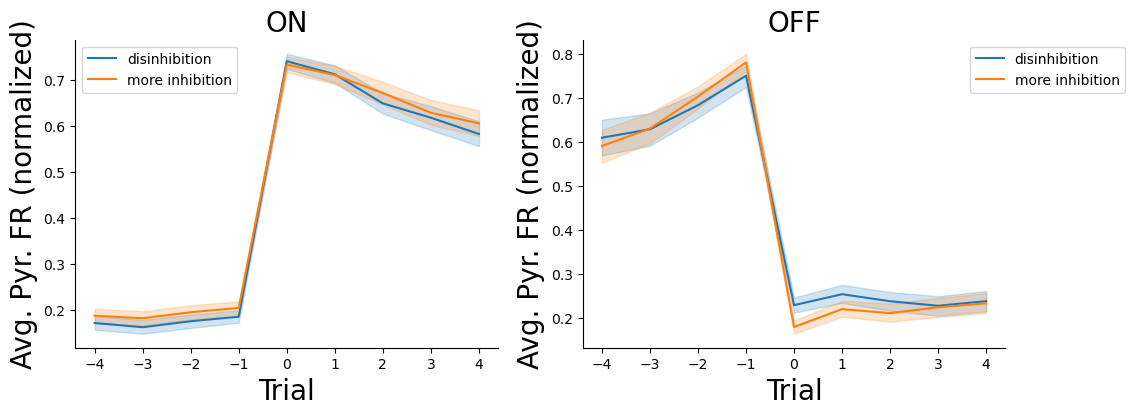

In [180]:
reload(ph)
fig,axs=plt.subplots(1,2,figsize=(12,4))
sw_key_d = {1:'ON',-1:'OFF'}
for ii,(sw,X_raw_selected_all_d) in enumerate(X_raw_selected_all_d_bothsw.items()):
    ax=axs[ii]
    cols_reset=np.arange(-trial_win,trial_win+1)
    if do_norm:
        var_name = 'Avg. Pyr. FR (normalized)'
    else:
        var_name = 'Avg. Pyr. FR'
    for k,val in X_raw_selected_all_d.items():
        fig,ax=ph.mean_across_row_vs_col_with_err(val,ax=ax,value_name=var_name,cols_reset=cols_reset,label=k)
    plt.legend(bbox_to_anchor=[1.3,1])
    ax.set_title(sw_key_d[sw])
    sns.despine()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

disinhibition vs. more inhibition: Mann-Whitney-Wilcoxon test two-sided, P_val:8.300e-01 U_stat=3.067e+05
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

disinhibition vs. more inhibition: Mann-Whitney-Wilcoxon test two-sided, P_val:1.167e-03 U_stat=1.162e+05


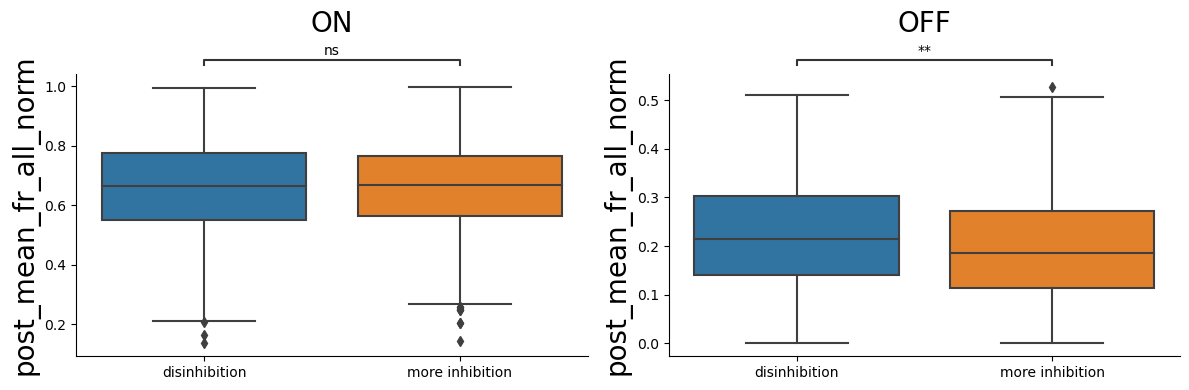

In [198]:
fig,axs=plt.subplots(1,2,figsize=(12,4))
for ii,sw in enumerate([1,-1]):
    sw_key = {1:'ON',-1:'OFF'}[sw]
    ax=axs[ii]
    data=all_sw_with_inh_change_all.query('switch==@sw')
    thresh=0
#     metric_key = 'pre_mean_fr_all_norm'
    metric_key = 'post_mean_fr_all_norm'
    # metric_key = 'pre_ntrial_ge_30_perc_frac_total'
    # metric_key = 'pre_mean_fr_all'

    inh_key = 'selected_inh_fr_change'
    ma = data[inh_key]<-thresh
    xx=data.loc[ma,metric_key].dropna()
    # ax=xx.hist(label='disinhibition',alpha=0.3,density=True,grid=False,bins=20)

    ma = data[inh_key]>thresh
    yy=data.loc[ma,metric_key].dropna()
    # ax=yy.hist(label='more inhibition',ax=ax,alpha=0.3,density=True,grid=False,bins=20)
    # ax.legend()
    # ax.set_ylabel('Density')
    # ax.set_xlabel(metric_key)
    # ax.set_title(f'switch={sw}')


    toplot=pd.concat({'disinhibition':pd.Series(xx.values),'more inhibition':pd.Series(yy.values)}).reset_index(level=0)
    toplot.columns=['type',metric_key]



    from statannotations.Annotator import Annotator

    x='type'
    y=metric_key
    # ax = sns.violinplot(data=toplot,x=x,y=y)
    ax = sns.boxplot(data=toplot,x=x,y=y,ax=ax)
    pairs=[('disinhibition','more inhibition')]
    annotator=Annotator(ax,pairs,data=toplot,x=x,y=y)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()

    # ax.set(ylabel='Num. Trial before switch\n>=30% max',xlabel='')
    ax.set(ylabel=metric_key,xlabel='')
    ax.set_title(sw_key,y=1.,pad=30)


    sns.despine()

    # ph.plot_cdf_and_ks_test(xx,yy)
    # print(scipy.stats.ranksums(xx,yy))
plt.tight_layout()


In [206]:
# alex's within field idea:

data = copy.copy(consec_trial_fr_diff_all)
inh_key = 'inh'#'selected_inh'#'inh'
data['disinhibition'] = data[inh_key] < -inh_thresh

pyr_thresh = 0.1
# ma= (data['pyr_1']>pyr_thresh)
ma= (data['pyr_1']<-pyr_thresh)
data_sub=data.loc[ma]


# data_grp_by_disinhibition_mean=data.set_index('disinhibition',append=True).groupby(level=(0,1,2,3,4,6),sort=False).mean()
data_grp_by_disinhibition_mean=data.set_index('disinhibition',append=True).groupby(level=(0,1,2,3,4,6),sort=False).median()
data_grp_by_disinhibition_mean_diff = data_grp_by_disinhibition_mean.groupby(level=(0,1,2,3,4)).apply(lambda x: x.iloc[1]-x.iloc[0] if x.shape[0]==2 else x.iloc[0]*np.nan ).dropna(axis=0,how='all')


# data_sub_grp_by_disinhibition_mean = data_sub.set_index('disinhibition',append=True).groupby(level=(0,1,2,3,4,6),sort=False).mean()
# data_sub_grp_by_disinhibition_mean_diff = data_sub_grp_by_disinhibition_mean.groupby(level=(0,1,2,3,4)).apply(lambda x:x.iloc[0]-x.iloc[1] if x.shape[0]==2 else x.iloc[0]*np.nan).dropna(axis=0,how='all')


data_sub['disinhibition'] = data_sub[inh_key] < -inh_thresh
gpb = data_sub.groupby(level=(0,1,2,3,4),sort=False)
comparison_d = {}
for k,val in gpb:
    xx=val.groupby('disinhibition').mean()
#     xx=val.groupby('disinhibition').median()
    try:
        comparison = xx.loc[False] - xx.loc[True] 
        comparison=comparison.loc['pyr_1':'pyr_4']
        comparison_d[k] = comparison
    except:
        pass
        
comparison_d = pd.concat(comparison_d,axis=0)
comparison_d=comparison_d.unstack()
data_sub_grp_by_disinhibition_mean_diff = comparison_d

# scipy.stats.wilcoxon(comparison_d['pyr_4'].dropna(),alternative='less')

baseline=data_grp_by_disinhibition_mean_diff.loc[:,'pyr_1':'pyr_4'] > 0
toplot=data_sub_grp_by_disinhibition_mean_diff.loc[:,'pyr_1':'pyr_4'] > 0

/tmp/ipykernel_655924/641716483.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['disinhibition'] = data_sub[inh_key] < -inh_thresh


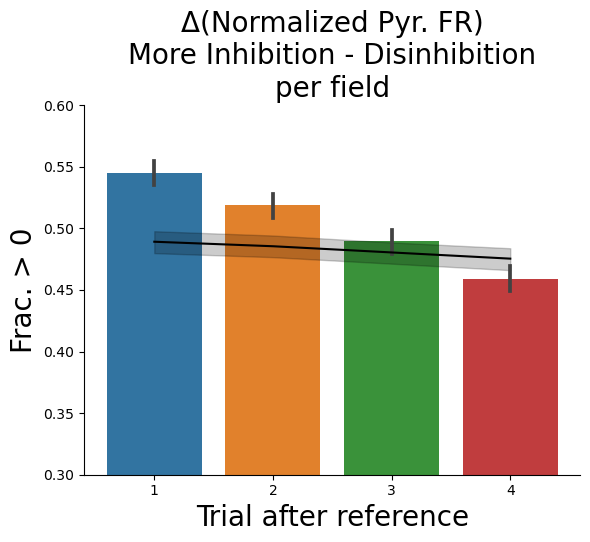

In [207]:
reload(ph)
# ax=sns.barplot(data=toplot.melt(var_name='Trial after reference'),x='Trial after reference',y='value')
cols_reset = None#np.arange(1,5)
fig,ax=ph.mean_across_row_vs_col_with_err(toplot,var_name='Trial after reference',integer_x=True,cols_reset=cols_reset,value_name='Frac. > 0',plot_type='bar')
ax.set_xticks(range(0,4))
ax.set_xticklabels(range(1,5))
ph.mean_across_row_vs_col_with_err(baseline,ax=ax,color='k',cols_reset=cols_reset,integer_x=True)
# ax.set_ylabel('Frac. > 0')

ax.set_ylim([0.3,0.6])
ax.set_title(u'Δ(Normalized Pyr. FR)\nMore Inhibition - Disinhibition\nper field')
sns.despine()

# switch triggered inh fr change

In [122]:
sw=-1#1
sw_key_d={1:'ON',-1:'OFF'}
inh_thresh = 0
sw_ma = all_sw_with_inh_change_all['switch']==sw
if sw==1:
    quality_ma=all_sw_with_inh_change_all['pre_ntrial_ge_30_perc_frac_total'] < 0.1
#     quality_ma=(all_sw_with_inh_change_all['pre_ntrial_ge_30_perc_frac_total'] < 0.1)&(all_sw_with_inh_change_all['post_ntrial_ge_50_perc_frac_total'] > 0.6)
#     quality_ma=(all_sw_with_inh_change_all['post_ntrial_ge_50_perc_frac_total'] > 0.6)
else:
    quality_ma=all_sw_with_inh_change_all['post_ntrial_ge_30_perc_frac_total'] < 0.1

inh_ma = all_sw_with_inh_change_all['inh_fr_change'].abs()>1
# ma = sw_ma & quality_ma & inh_ma
# ma = sw_ma & quality_ma 
# ma = sw_ma & inh_ma
ma = sw_ma

# ma = (all_sw_with_inh_change_all['switch']==1)&(all_sw_with_inh_change_all['inh_fr_change'].abs()>1)





In [141]:
ma_d = {'sw on':data['has_sw_on'],'sw off':data['has_sw_off'],'no sw':np.logical_and(~data['has_sw_on'],~~data['has_sw_off'])}




In [153]:
inh_change_d = {}
for k,val in ma_d.items():
    inh_change_d[k] = data.loc[val][['inh','selected_inh']].reset_index(drop=True)
inh_change_d = pd.concat(inh_change_d,axis=0).reset_index(level=0)
    

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

sw off vs. no sw: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=4.666e+05
sw on vs. no sw: Mann-Whitney-Wilcoxon test two-sided, P_val:1.519e-05 U_stat=8.792e+05


[Text(0.5, 15.0, '')]

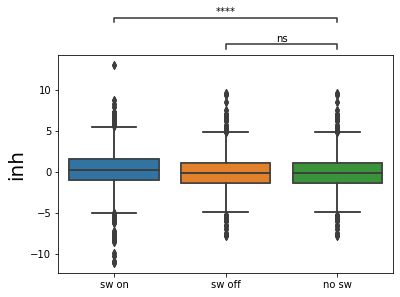

In [159]:
sns.boxplot(data=inh_change_d,x='level_0',y='inh')
from statannotations.Annotator import Annotator

x='level_0'
y='inh'
# ax = sns.violinplot(data=toplot,x=x,y=y)
ax = sns.boxplot(data=inh_change_d,x=x,y=y)
pairs=[('sw on','no sw'),('sw off','no sw')]
annotator=Annotator(ax,pairs,data=inh_change_d,x=x,y=y)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()
ax.set(xlabel='')


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

sw off vs. no sw: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=4.666e+05
sw on vs. no sw: Mann-Whitney-Wilcoxon test two-sided, P_val:2.951e-08 U_stat=6.949e+05


[Text(0.5, 15.0, '')]

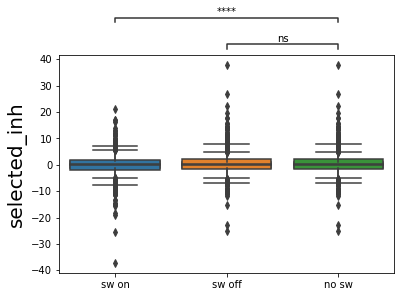

In [161]:
sns.boxplot(data=inh_change_d,x='level_0',y='inh')
from statannotations.Annotator import Annotator

x='level_0'
y='selected_inh'
# ax = sns.violinplot(data=toplot,x=x,y=y)
ax = sns.boxplot(data=inh_change_d,x=x,y=y)
pairs=[('sw on','no sw'),('sw off','no sw')]
annotator=Annotator(ax,pairs,data=inh_change_d,x=x,y=y)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()
ax.set(xlabel='')


WilcoxonResult(statistic=245395.0, pvalue=2.693043246248307e-06)


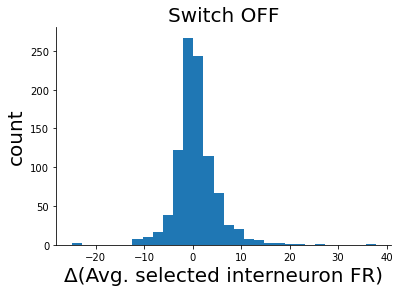

In [160]:
inh_key = 'selected_inh_fr_change'
# inh_key = 'inh_fr_change'
toplot = all_sw_with_inh_change_all.loc[ma][inh_key].dropna()
ax=toplot.hist(bins=30,grid=False,density=False)
sns.despine()
sw_key = sw_key_d[sw]
title = f'Switch {sw_key}'
ax.set(xlabel=u'Δ(Avg. selected interneuron FR)',ylabel='count',title=title)
print(scipy.stats.wilcoxon(toplot,alternative='greater'))

# complement = all_sw_with_inh_change_all.loc[~ma][inh_key].dropna()
# print(scipy.stats.wilcoxon(complement,alternative='greater'))

# print(scipy.stats.ranksums(toplot,complement,alternative='greater'))



In [11]:
data=consec_trial_fr_diff_all
manual_sw_ma_on = (data.loc[:,'pyr_1'] > 0.4) & ((data.loc[:,'pyr_2':'pyr_4'] > 0.4).sum(axis=1) >= 2)

WilcoxonResult(statistic=3012346.0, pvalue=0.9999191097625622)

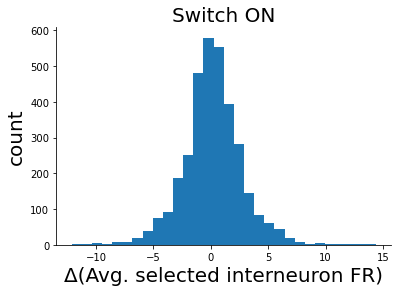

In [277]:
inh_key = 'inh'#'selected_inh'
ma = manual_sw_ma_on
# inh_key = 'inh_fr_change'
toplot = consec_trial_fr_diff_all.loc[ma][inh_key].dropna()
ax=toplot.hist(bins=30,grid=False,density=False)
sns.despine()
sw_key = sw_key_d[sw]
title = f'Switch {sw_key}'
ax.set(xlabel=u'Δ(Avg. selected interneuron FR)',ylabel='count',title=title)
scipy.stats.wilcoxon(toplot,alternative='less')

In [68]:
# proportion of uptick that turns into switch
from statsmodels.stats.proportion import proportions_ztest
pyr_thresh = 0.#0.
inh_thresh = 0.#0
inh_key = 'selected_inh'#'inh'#
sw_key = 'has_sw_on'#'has_sw_off'
ma=(data['pyr_1']>pyr_thresh) & (data[inh_key]<-inh_thresh)
# ma= (data[inh_key]<-inh_thresh)
xx=data.loc[ma][sw_key]

ma=(data['pyr_1']>pyr_thresh) & (data[inh_key]>inh_thresh)
# ma= (data[inh_key]>inh_thresh)
yy=data.loc[ma][sw_key]

count=np.array([xx.sum(),yy.sum()])
nobs=np.array([len(xx),len(yy)])

proportions_ztest(count,nobs)

(1.1452834113377315, 0.25209177541752514)

In [69]:
# proportion of uptick that turns into switch
from statsmodels.stats.proportion import proportions_ztest
pyr_thresh = 0.
inh_thresh = 0
inh_key = 'selected_inh'#'inh'#
sw_key = 'has_sw_off'#'has_sw_off'
# ma=(data['pyr_1']>pyr_thresh) & (data['inh']<-inh_thresh)
ma= (data[inh_key]<-inh_thresh)
xx=data.loc[ma][sw_key]

# ma=(data['pyr_1']>pyr_thresh) & (data['inh']>inh_thresh)
ma= (data[inh_key]>inh_thresh)
yy=data.loc[ma][sw_key]

count=np.array([xx.sum(),yy.sum()])
nobs=np.array([len(xx),len(yy)])

proportions_ztest(count,nobs)

(-3.970793113795248, 7.163376487662105e-05)

In [16]:
# proportion of uptick that turns into switch
from statsmodels.stats.proportion import proportions_ztest
pyr_thresh = 0.
inh_thresh = 0
inh_key = 'inh'#'selected_inh'
sw_key = 'has_sw_on'#'has_sw_off'
# ma=(data['pyr_1']>pyr_thresh) & (data['inh']<-inh_thresh)
ma= (data[inh_key]<-inh_thresh)
xx=data.loc[ma][sw_key]

# ma=(data['pyr_1']>pyr_thresh) & (data['inh']>inh_thresh)
ma= (data[inh_key]>inh_thresh)
yy=data.loc[ma][sw_key]

count=np.array([xx.sum(),yy.sum()])
nobs=np.array([len(xx),len(yy)])

proportions_ztest(count,nobs)

(-4.83901321112459, 1.304853737995567e-06)

In [17]:
# baseline, proportion of upticks/downticks

from statsmodels.stats.proportion import proportions_ztest
pyr_thresh = 0.
inh_thresh = 0
inh_key = 'inh'#'selected_inh'#'inh'
sw_key = 'has_sw_off'#'has_sw_on'
# ma=(data['pyr_1']>pyr_thresh) & (data['inh']<-inh_thresh)
ma= (data[inh_key]<-inh_thresh)
xx=data.loc[ma]['pyr_1'] > pyr_thresh
# xx=data.loc[ma]['pyr_1'] <-pyr_thresh

# ma=(data['pyr_1']>pyr_thresh) & (data['inh']>inh_thresh)
ma= (data[inh_key]>inh_thresh)
yy=data.loc[ma]['pyr_1'] > pyr_thresh
# yy=data.loc[ma]['pyr_1'] < -pyr_thresh

count=np.array([xx.sum(),yy.sum()])
nobs=np.array([len(xx),len(yy)])

proportions_ztest(count,nobs)

(-36.113467623676094, 1.39411121147289e-285)

In [ ]:
# inh_key = 'selected_inh_fr_change'
inh_key = 'inh_fr_change'
toplot = all_sw_with_inh_change_all.loc[ma][inh_key].dropna()
ax=toplot.hist(bins=30,grid=False,density=False)
sns.despine()
sw_key = sw_key_d[sw]
title = f'Switch {sw_key}'
ax.set(xlabel=u'Δ(Avg. selected interneuron FR)',ylabel='count',title=title)
scipy.stats.wilcoxon(toplot,alternative='less')

In [12]:
data_dir_full = subdb.iloc[1]['data_dir_full']

In [13]:
data_dir_full

'/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117'

In [112]:
%%time
reload(saiw)
reload(pp)
res = saiw.main(data_dir_full)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/fr_map_with_int.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_afterheadscan_recombine.p exists; loading---


/mnt/home/szheng/projects/place_variability/code/sw_and_int_withreg.py:78: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_field_metrics_one = per_field_metrics_all.loc[(ani,sess),:]


saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_and_int_pen_5e-01.p
CPU times: user 3min 15s, sys: 2min 7s, total: 5min 23s
Wall time: 1min 51s


In [113]:
consec_trial_fr_diff_all = res['consec_trial_fr_diff_all']

(<Figure size 432x288 with 1 Axes>, <Axes: xlabel='Trial', ylabel='value'>)

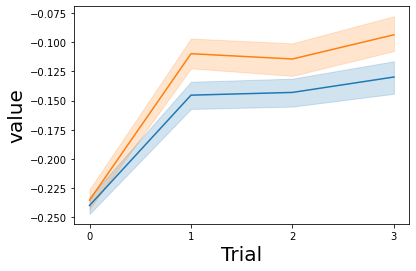

In [95]:
data = consec_trial_fr_diff_all
pyr_thresh = 0
inh_thresh = 0
inh_key = 'selected_inh'#'inh'
# ma= (data[inh_key]<-inh_thresh) & (data['pyr_1']>pyr_thresh) 
ma= (data[inh_key]<-inh_thresh) & (data['pyr_1']<-pyr_thresh) 
toplot=data.loc[ma].loc[:,'pyr_1':'pyr_4']
fig,ax=ph.mean_across_row_vs_col_with_err(toplot)
 
# ma= (data[inh_key]>inh_thresh) & (data['pyr_1']>pyr_thresh) 
ma= (data[inh_key]>inh_thresh) & (data['pyr_1']<-pyr_thresh) 
toplot=data.loc[ma].loc[:,'pyr_1':'pyr_4']
ph.mean_across_row_vs_col_with_err(toplot,fig=fig,ax=ax)

TtestResult(statistic=-5.862730602776529, pvalue=4.676999107774126e-09, df=11617)

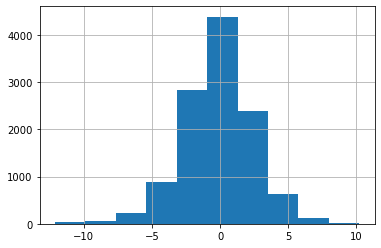

In [63]:
consec_trial_fr_diff_all['inh'].hist()
scipy.stats.ttest_1samp(consec_trial_fr_diff_all['inh'].dropna(),0)

In [87]:
pyr_thresh=0.1
ma=(data_sub.loc[:,'pyr_1':'pyr_4']<-pyr_thresh).any(axis=1)

In [88]:
ma = (data.loc[:,'pyr_1':'pyr_4']<-pyr_thresh).all(axis=1)
data_consec_down = data.loc[ma]

TtestResult(statistic=-9.341359470141716, pvalue=3.4760658906170974e-19, df=484)

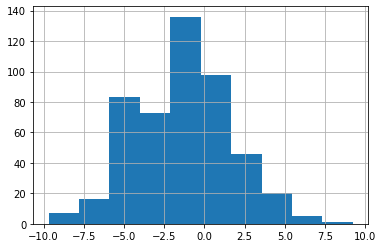

In [69]:
ma = (data['pyr_1']<-pyr_thresh) & ((data['pyr_2']<-pyr_thresh / 2) ) & ((data['pyr_3']<-pyr_thresh / 2) ) & ((data['pyr_4']<-pyr_thresh / 2) )
xx=consec_trial_fr_diff_all.loc[ma]['inh'].dropna()
xx.hist()
scipy.stats.ttest_1samp(xx,0)

In [119]:
allsw_data= res['all_sw_with_metrics_oneti_with_inh_change']

In [122]:
consec_trial_fr_diff_all.loc[('both',186,0,1),:]

inh               0.287513
selected_inh     -2.012957
pyr_1             0.816537
pyr_2             1.000000
pyr_3             0.694807
pyr_4             0.541285
int_1             0.287513
int_2             2.126550
int_3            -0.221812
int_4            -0.719163
selected_int_1   -2.012957
selected_int_2    1.333231
selected_int_3    0.049280
selected_int_4   -2.622992
fr_prior          0.051988
Name: (both, 186, 0, 1), dtype: float64

In [128]:
name_l

'sw_and_int_pen_5e-01_pthresh_5e-02.p'

<Axes: >

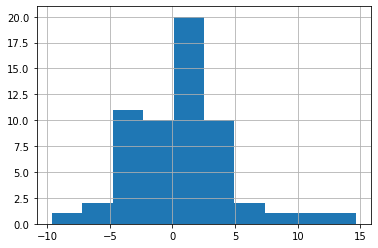

In [125]:
allsw_data.query('switch==-1')['selected_inh_fr_change'].hist()

In [104]:
data_sub = {}
data=consec_trial_fr_diff_all
for _,row in allsw_data.query('switch==-1')[['trialtype','uid','field_index','switch_trial']].iterrows():
    tt,uid,field_id,sw_tr = row
    data_sub[(tt,uid,field_id,sw_tr)]=data.loc[(tt,uid,field_id,sw_tr-1)]
data_sub = pd.concat(data_sub,axis=0).unstack()

In [48]:
data.loc[(tt,uid,field_id,sw_tr-1)]

inh              -1.714699
selected_inh     -2.327459
pyr_1            -0.739283
pyr_2            -0.519725
pyr_3            -0.567592
pyr_4                  NaN
int_1            -1.714699
int_2             1.227974
int_3             0.864661
int_4                  NaN
selected_int_1   -2.327459
selected_int_2    1.018064
selected_int_3    0.934245
selected_int_4         NaN
fr_prior          0.646469
Name: (0.0, 357, 0, 16), dtype: float64

TtestResult(statistic=1.3618234226712504, pvalue=0.17851991243226892, df=58)

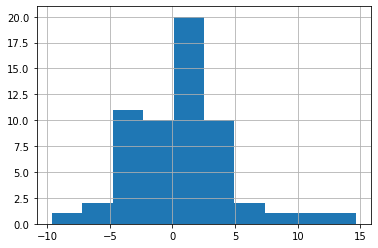

In [105]:
data_sub['selected_inh'].hist()
scipy.stats.ttest_1samp(data_sub['selected_inh'],0)

TtestResult(statistic=-0.3536538883294875, pvalue=0.7248806088518134, df=58)

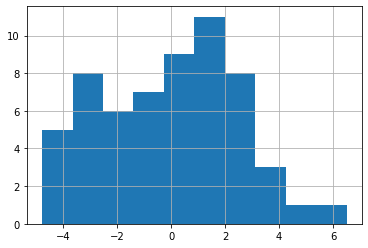

In [106]:
data_sub['inh'].hist()
scipy.stats.ttest_1samp(data_sub['inh'],0)

In [58]:
scipy.stats.ranksums(data_sub['selected_inh'],data_sub['inh'],'greater')

RanksumsResult(statistic=1.2782880961619871, pvalue=0.10057393175731799)

(<Figure size 432x288 with 1 Axes>, <Axes: xlabel='Trial', ylabel='value'>)

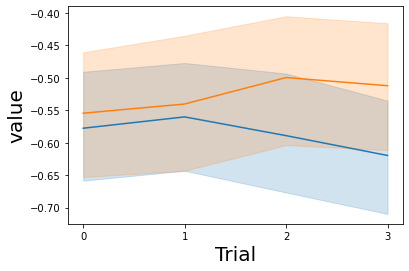

In [110]:

pyr_thresh = 0
inh_thresh = 0
ma= (data_sub['inh']<-inh_thresh) 
toplot=data_sub.loc[ma].loc[:,'pyr_1':'pyr_4']
fig,ax=ph.mean_across_row_vs_col_with_err(toplot)

ma= (data_sub['inh']>inh_thresh) 
toplot=data_sub.loc[ma].loc[:,'pyr_1':'pyr_4']
ph.mean_across_row_vs_col_with_err(toplot,fig=fig,ax=ax)

In [ ]:
data_sub['selected_inh']

In [52]:
data_sub['inh']

inh  selected_inh     pyr_1     pyr_2     pyr_3  \
0.0  40  0 10.0  2.281065      4.555016 -0.415491 -0.352683 -0.441702   
     73  1 8.0   0.283489     -0.353984 -0.483503 -0.700995 -0.475463   
     78  1 2.0  -1.855111     -0.815355 -0.596647 -0.845548 -0.762575   
     88  1 4.0   0.015409      0.190847 -0.200398 -0.191075 -0.367835   
     99  2 9.0   1.218122      2.973748 -0.280397 -0.263636 -0.207244   
     105 0 15.0 -3.416544     -5.783025 -0.336410 -0.128341 -0.210997   
     106 0 8.0   2.816677      0.923801 -0.256317  0.067025 -0.043078   
     114 1 12.0 -1.392439     -3.600285 -0.602487 -0.408041 -0.210495   
     126 0 4.0  -1.863210     -2.490403 -0.625050 -0.642604 -0.473922   
     132 1 4.0  -3.204635      5.551764 -0.400415 -0.405752 -0.414862   
     137 2 7.0  -1.573124     -1.206338 -0.498928 -0.198991 -0.481506   
     143 0 8.0   2.147153      1.616834 -0.440498 -0.513323 -0.635312   
         1 10.0 -0.397649     -0.762890 -0.907598 -0.881012 -0.983050   
     168 0 13.0 -0.360635     -0.242300 -0.502543 -0.479804 -0.548179   
     170 1 4.0  -4.582939     -2.650992 -0.397299 -0.613076 -0.696395   
     183 0 9.0   1.223300      3.304880 -0.922218 -0.799298 -1.000000   
     194 0 9.0   0.018503      0.294199 -0.477841 -0.271874 -0.248277   
     209 0 11.0 -0.434838      2.500265 -0.491756 -0.626997 -0.677055   
     212 0 4.0  -3.662822     -2.528244 -0.744673 -0.549779 -0.757425   
     218 1 10.0 -4.623978     -4.177559 -0.293076 -0.501647 -0.334602   
     219 0 4.0  -3.425458     -4.143284 -0.278010 -0.294035 -0.278658   
     220 1 8.0   2.291692      2.090021 -0.176188 -0.387497 -0.214445   
     248 0 7.0  -3.370468     -3.217592 -0.161522  0.008677 -0.452616   
     257 0 2.0   1.108776      1.700562 -0.553267 -0.756733 -0.652729   
     268 1 6.0   0.929151      1.895634 -0.723067 -0.833435 -0.550998   
     272 2 11.0 -0.080277      1.600376 -0.416960 -0.453450 -0.209219   
     284 1 3.0  -3.608149     -5.975913 -0.523473 -0.679166 -0.635510   
     295 1 8.0   3.231539      2.372160 -0.894502 -0.894502 -0.799483   
     304 0 3.0   6.495796      9.592388 -0.533154  0.035439 -0.128829   
     333 0 3.0  -3.137089     -3.107602 -0.521332 -0.578574 -0.872787   
     338 0 10.0  2.628658      4.736675 -0.789985 -0.715312 -0.934775   
     339 0 5.0   3.584330     14.661289 -0.928936 -1.000000 -0.415191   
     349 1 8.0   3.083005      2.128930 -0.652736 -0.535059 -0.326270   
     357 0 17.0 -1.714699     -2.327459 -0.739283 -0.519725 -0.567592   
     373 0 3.0  -2.542980      1.009837 -1.000000 -1.000000 -0.905847   
1.0  43  2 5.0  -0.470228     -2.249860 -0.727038 -0.717015 -0.776544   
     77  0 6.0   1.630864      4.376403 -0.676697 -0.754881 -0.472076   
     101 0 8.0  -1.979178     -3.801526 -0.682025 -0.477156 -0.685821   
     111 0 5.0   1.525063      1.650931 -0.090968 -0.393431 -0.411651   
     210 1 7.0  -0.131004      2.518994 -0.777602 -0.872219 -0.792876   
     259 0 6.0   0.994083      0.858330 -1.000000 -0.856118 -1.000000   
     260 0 3.0  -1.979364      2.206921 -1.000000 -1.000000 -1.000000   
     276 0 2.0   3.520703     10.197992 -0.693381 -1.000000 -0.113216   
     304 0 2.0   1.823069      5.312102 -0.816864 -0.612150 -0.896669   
     321 1 5.0   2.905138      3.413913 -0.506596 -0.483361 -0.442771   
     323 0 3.0   0.171598     -2.221320 -0.821843 -0.821843 -0.821843   
     360 0 2.0  -0.823928     -0.610359 -0.834656 -0.774662 -0.679954   
both 67  0 25.0 -4.558681     -3.191559 -0.646078 -0.551514 -0.458687   
     88  0 8.0  -0.123125      1.410007 -0.961600 -0.838162 -1.000000   
     117 1 21.0 -4.775510     -9.631822 -0.584542 -0.347179 -0.729261   
     164 0 20.0  0.177643      2.459425 -0.604359 -0.604359 -0.332074   
     186 0 9.0  -0.174529      0.549743 -0.292925 -0.591070 -0.113515   
     210 0 12.0  1.834268      2.653684 -0.154524 -0.139874 -0.543312   
     270 0 8.0  -1.340032     -1.305932 -0.564500 -0.499353 -0.469617   
     28

In [27]:
consec_trial_fr_diff_all

inh  selected_inh     pyr_1     pyr_2     pyr_3     pyr_4  \
0.0  31  1 0  -1.065279      1.076358  0.133460  0.447060  0.268841  0.085349   
           1   5.863067      7.518044  0.313600  0.135380 -0.048112  0.125014   
           2  -5.377270     -8.281112 -0.178219 -0.361711 -0.188586 -0.434112   
           3  -2.091700     -2.571492 -0.183492 -0.010366 -0.255893 -0.035915   
           4   2.434154      5.846633  0.173126 -0.072401  0.147577  0.126617   
...                 ...           ...       ...       ...       ...       ...   
both 376 0 27  4.226136      3.547128 -0.008691 -0.069911 -0.143760 -0.136385   
           28 -7.062527     -4.733037 -0.061221 -0.135069 -0.127694       NaN   
           29  0.847759      0.289402 -0.073848 -0.066474       NaN       NaN   
           30 -0.618051      0.096716  0.007375       NaN       NaN       NaN   
           31       NaN           NaN       NaN       NaN       NaN       NaN   

                  int_1     int_2     int_3     int_4  selected_int_1  \
0.0  31  1 0  -1.065279  4.797787 -0.579483 -2.671183        1.076358   
           1   5.863067  0.485797 -1.605903  0.828251        7.518044   
           2  -5.377270 -7.468970 -5.034816 -5.298753       -8.281112   
           3  -2.091700  0.342454  0.078517 -0.105857       -2.571492   
           4   2.434154  2.170217  1.985843  2.017440        5.846633   
...                 ...       ...       ...       ...             ...   
both 376 0 27  4.226136 -2.836390 -1.988632 -2.606683        3.547128   
           28 -7.062527 -6.214768 -6.832819       NaN       -4.733037   
           29  0.847759  0.229707       NaN       NaN        0.289402   
           30 -0.618051       NaN       NaN       NaN        0.096716   
           31       NaN       NaN       NaN       NaN             NaN   

               selected_int_2  selected_int_3  selected_int_4  fr_prior  
0.0  31  1 0         8.594402        0.313290       -2.258202  0.278431  
           1        -0.763068       -3.334560        2.512073  0.345161  
           2       -10.852604       -5.005971       -7.006649  0.471938  
           3         3.275141        1.274463       -0.713048  0.490771  
           4         3.845955        1.858444        3.801299  0.465373  
...                       ...             ...             ...       ...  
both 376 0 27       -1.185909       -0.896507       -0.799791  0.344649  
           28       -4.443635       -4.346919             NaN  0.338540  
           29        0.386118             NaN             NaN  0.330798  
           30             NaN             NaN             NaN  0.321173  
           31             NaN             NaN             NaN       NaN  

[12300 rows x 15 columns]

In [26]:
consec_trial_fr_diff_all

inh  selected_inh     pyr_1     pyr_2     pyr_3     pyr_4  \
0.0  31  1 0  -1.065279      1.076358  0.133460  0.447060  0.268841  0.085349   
           1   5.863067      7.518044  0.313600  0.135380 -0.048112  0.125014   
           2  -5.377270     -8.281112 -0.178219 -0.361711 -0.188586 -0.434112   
           3  -2.091700     -2.571492 -0.183492 -0.010366 -0.255893 -0.035915   
           4   2.434154      5.846633  0.173126 -0.072401  0.147577  0.126617   
...                 ...           ...       ...       ...       ...       ...   
both 376 0 27  4.226136      3.547128 -0.008691 -0.069911 -0.143760 -0.136385   
           28 -7.062527     -4.733037 -0.061221 -0.135069 -0.127694       NaN   
           29  0.847759      0.289402 -0.073848 -0.066474       NaN       NaN   
           30 -0.618051      0.096716  0.007375       NaN       NaN       NaN   
           31       NaN           NaN       NaN       NaN       NaN       NaN   

                  int_1     int_2     int_3     int_4  selected_int_1  \
0.0  31  1 0  -1.065279  4.797787 -0.579483 -2.671183        1.076358   
           1   5.863067  0.485797 -1.605903  0.828251        7.518044   
           2  -5.377270 -7.468970 -5.034816 -5.298753       -8.281112   
           3  -2.091700  0.342454  0.078517 -0.105857       -2.571492   
           4   2.434154  2.170217  1.985843  2.017440        5.846633   
...                 ...       ...       ...       ...             ...   
both 376 0 27  4.226136 -2.836390 -1.988632 -2.606683        3.547128   
           28 -7.062527 -6.214768 -6.832819       NaN       -4.733037   
           29  0.847759  0.229707       NaN       NaN        0.289402   
           30 -0.618051       NaN       NaN       NaN        0.096716   
           31       NaN       NaN       NaN       NaN             NaN   

               selected_int_2  selected_int_3  selected_int_4  fr_prior  
0.0  31  1 0         8.594402        0.313290       -2.258202  0.278431  
           1        -0.763068       -3.334560        2.512073  0.345161  
           2       -10.852604       -5.005971       -7.006649  0.471938  
           3         3.275141        1.274463       -0.713048  0.490771  
           4         3.845955        1.858444        3.801299  0.465373  
...                       ...             ...             ...       ...  
both 376 0 27       -1.185909       -0.896507       -0.799791  0.344649  
           28       -4.443635       -4.346919             NaN  0.338540  
           29        0.386118             NaN             NaN  0.330798  
           30             NaN             NaN             NaN  0.321173  
           31             NaN             NaN             NaN       NaN  

[12300 rows x 15 columns]